# Emissions to forcing for ozone

Keep the AR6 treatment in FaIR v1.6.2+ and remove all previous incarnations.

We'll calculate the GHG concentrations from emissions first, and then use both to calculate ozone forcing along with the temperaute feedback.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

from fair21.forcing.ozone import thornhill_skeie
from fair21.constants.gases import molwt, burden_per_emission, lifetime, gas_list
from fair21.constants.short_lived_forcers import slcf_list
# TODO: gas_list and slcf_list to be moved to some sort of defaults.scenarios module
from fair21.defaults.gases import (
    partition_fraction,
    pre_industrial_concentration,
    natural_emissions_adjustment,
    iirf_0,
    iirf_cumulative,
    iirf_temperature,
    iirf_airborne,
    iirf_horizon
)
from fair21.gas_cycle import (
    calculate_g,
    calculate_alpha,
    step_concentration_1box,
    step_concentration_co2
)

In [2]:
# grab some emissions
emissions = {}
df = pd.read_csv('../data/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
for specie in gas_list + slcf_list:
    specie_rcmip_name = specie.replace("-", "")
    emissions[specie] = df.loc[
        (df['Scenario']=='ssp585') & (df['Variable'].str.endswith("|"+specie_rcmip_name)) & (df['Region']=='World'), '1750':
    ].interpolate(axis=1).values.squeeze()

# CO2 and N2O units need to behave
emissions["CO2"] = emissions["CO2"] / 1000
emissions["N2O"] = emissions["N2O"] / 1000

In [3]:
# initialise dicts for outputs. These will eventually be moved to the forward model
concentration = {}
airborne_emissions = {}
cumulative_emissions = {}
effective_radiative_forcing = {}

n_timesteps = len(emissions[specie])

In [4]:
# grab indicative temperature projections
df = pd.read_csv('../data/rcmip-phase2/rcmip-phase2-fair162-ssp585-mean-temperature.csv')
ssp585_temperature_rfmip = df['temperature'].values

In [5]:
concentration['CO2'] = np.ones(n_timesteps) * np.nan

co2_boxes = 0
airborne_emissions = 0
cumulative_emissions['CO2'] = np.cumsum(emissions['CO2'])

g0, g1 = calculate_g(lifetime['CO2'], partition_fraction=partition_fraction['CO2'])

for i in range(n_timesteps):
    alpha_lifetime = calculate_alpha(
        cumulative_emissions['CO2'][i],
        airborne_emissions,
        ssp585_temperature_rfmip[i],
        iirf_0["CO2"],
        iirf_cumulative["CO2"],
        iirf_temperature["CO2"],
        iirf_airborne["CO2"],
        g0,
        g1,
    )
    concentration['CO2'][i], co2_boxes, airborne_emissions = step_concentration_co2(
        emissions['CO2'][i], 
        co2_boxes,
        airborne_emissions, 
        burden_per_emission['CO2'],
        alpha_lifetime=alpha_lifetime,
        pre_industrial_concentration=pre_industrial_concentration['CO2'],
        timestep=1,
    )

In [6]:
concentration['CH4'] = np.ones(n_timesteps) * np.nan

ch4_boxes = 0
airborne_emissions = 0
concentration['CH4'][0] = pre_industrial_concentration['CH4']
cumulative_emissions['CH4'] = np.cumsum(emissions['CH4']) # cumulative emissions are not contributing to methane lifetime, but we'll track them in case future research makes them relevant

g0, g1 = calculate_g(lifetime['CH4'])

ch4_lifetime = np.ones(n_timesteps) * np.nan

for i in range(n_timesteps):
    alpha_lifetime = calculate_alpha(
        cumulative_emissions['CH4'][i],
        airborne_emissions,
        ssp585_temperature_rfmip[i],
        iirf_0["CH4"],
        iirf_cumulative["CH4"],
        iirf_temperature["CH4"],
        iirf_airborne["CH4"],
        g0,
        g1,
    )
    
    ch4_lifetime[i] = alpha_lifetime * lifetime['CH4']
    
    concentration['CH4'][i], airborne_emissions = step_concentration_1box(
        emissions['CH4'][i], 
        airborne_emissions, 
        lifetime['CH4'],
        burden_per_emission['CH4'],
        alpha_lifetime=alpha_lifetime,
        pre_industrial_concentration=pre_industrial_concentration['CH4'],
        timestep=1,
    )

In [7]:
for gas in gas_list:
    if gas in ['CH4', 'CO2']:
        continue  # done above and slightly different to rest!
    
    concentration[gas] = np.ones(n_timesteps) * np.nan

    airborne_emissions = 0

    for i in range(n_timesteps):
        concentration[gas][i], airborne_emissions = step_concentration_1box(
            emissions[gas][i], 
            airborne_emissions,
            lifetime[gas],
            burden_per_emission[gas],
            pre_industrial_concentration=pre_industrial_concentration[gas],
            timestep=1,
            natural_emissions_adjustment=natural_emissions_adjustment[gas]
        )

In [8]:
radiative_forcing, effective_radiative_forcing = thornhill_skeie(
    emissions,
    concentration,
    temperature=ssp585_temperature_rfmip
)

[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00

In [9]:
len(radiative_forcing.keys())

9

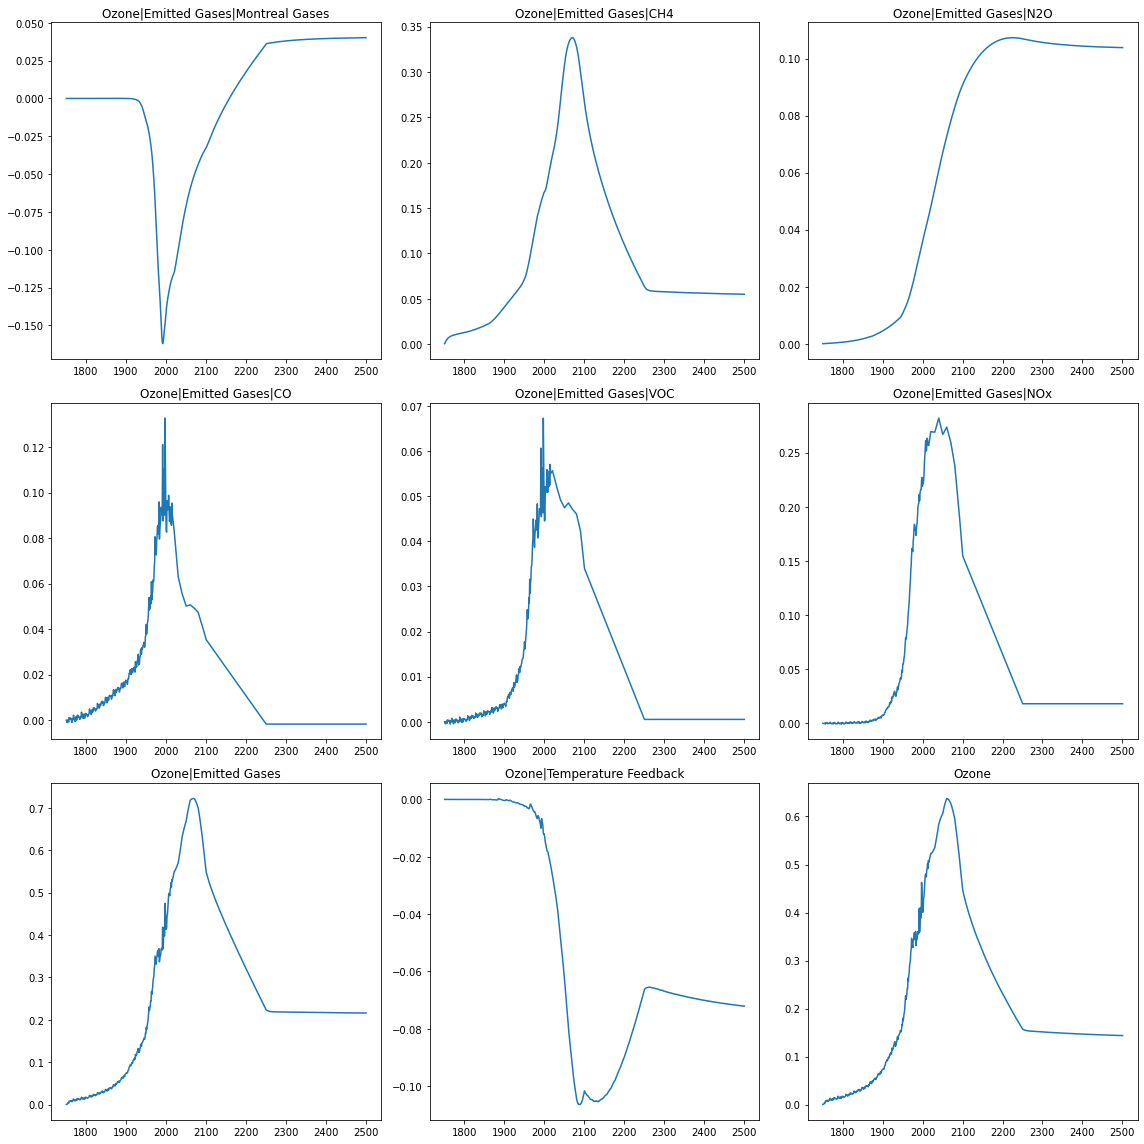

In [10]:
fig, ax = pl.subplots(3, 3, figsize=(16,16))
for icomp, component in enumerate(radiative_forcing):
    iy = icomp % 3
    ix = icomp // 3
    ax[ix, iy].plot(np.arange(1750.5, 2501), radiative_forcing[component], label='FaIR 2.1')
    ax[ix, iy].set_title(component)
fig.tight_layout()